In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats
import scipy.sparse
from ggplot import *
import itertools

In [15]:
#d = np.load('../arrival_time_arrays.npz')
d = np.load('../arrays_indirect_466_830_case1.npz')
d.files

['indirect_measured',
 'direct_simulated',
 'direct_measured',
 'indirect_simulated']

In [16]:
def bootstrap_samples(matrix, bootstrap_size, num_samples):
    a = matrix.flatten()
    probs = a.astype(float) / float(sum(a))
    for sample in range(num_samples):
        idxs = np.random.choice(len(a), size=bootstrap_size, replace=True, p=probs)
        s = np.zeros(len(a), dtype=int)
        for i in idxs:
            s[i] += 1
        yield s.reshape(matrix.shape)

In [17]:
def compare(ma, mb, mc, transfer, replicate):
    idxs = range(ma.shape[0])
    return pd.DataFrame({
        'facility': idxs, 'transfer': transfer, 'replicate': replicate,
        'measured_measured': [scipy.stats.pearsonr(ma[i,:], mb[i,:])[0] for i in idxs],
        'measured_simulated': [scipy.stats.pearsonr(ma[i,:], mc[i,:])[0] for i in idxs]
    })  

In [18]:
def bootstrap_test(bootstrap_size=10000, num_samples=1000):
    result = []
    replicate = 0
    for transfer in ['direct', 'indirect']:
        for dataset in [('measured','measured'), ('measured','simulated')]:
            for ma,mb,mc in zip(
                bootstrap_samples(d['%s_%s' % (transfer, dataset[0])], bootstrap_size, num_samples),
                bootstrap_samples(d['%s_%s' % (transfer, dataset[0])], bootstrap_size, num_samples),
                bootstrap_samples(d['%s_%s' % (transfer, dataset[1])], bootstrap_size, num_samples)):
                result.append(compare(ma,mb,mc,transfer,replicate))
                replicate += 1
    return pd.concat(result)

In [19]:
r = bootstrap_test()

In [20]:
r.head()

,facility,measured_measured,measured_simulated,replicate,transfer
0,0,0.940773,0.935063,0,direct
1,1,0.933611,0.917300,0,direct
2,2,0.968271,0.972200,0,direct
3,3,0.624861,0.739289,0,direct
4,4,0.963832,0.888163,0,direct


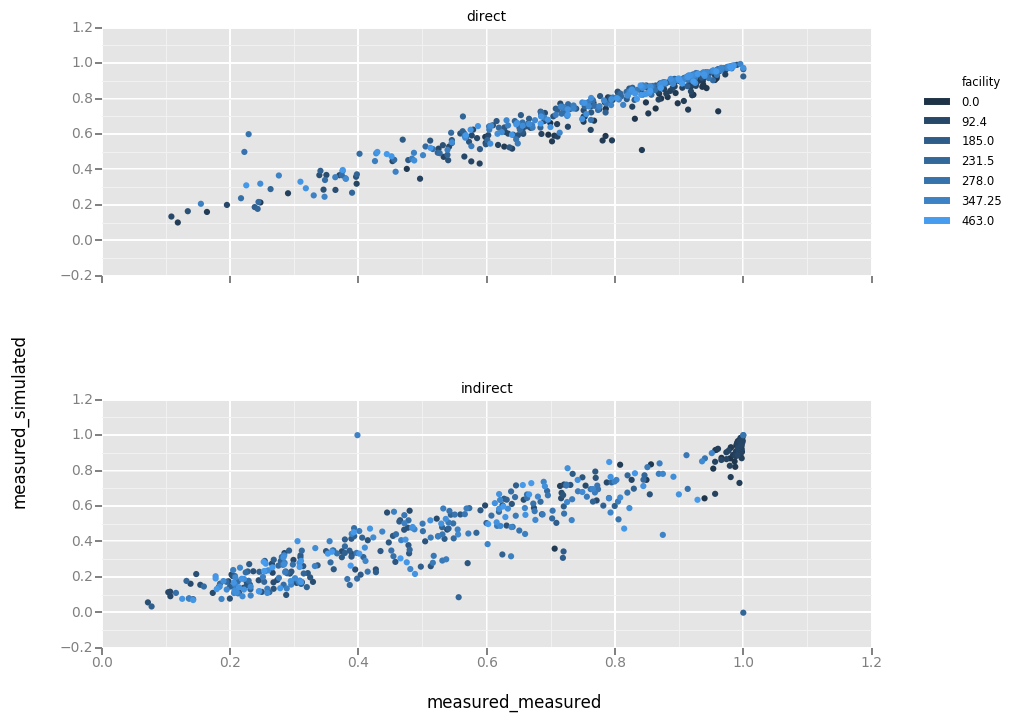

<ggplot: (8760625747421)>

In [21]:
ggplot(r.groupby(['facility','transfer'])[['measured_measured','measured_simulated']].mean().reset_index(),
       aes(x='measured_measured',y='measured_simulated',color='facility')) \
    + geom_point() + facet_wrap(x='transfer', scales='fixed')